# 🎯 Guided Backpropagation: Simple Tutorial

## What is Guided Backpropagation?

**Guided Backpropagation** is a visualization technique that shows which parts of an input image most strongly activate a neural network.

### Key Difference from Standard Backpropagation:
- **Standard Backprop**: Propagates all gradients (positive and negative)
- **Guided Backprop**: Only propagates **positive gradients** through ReLU layers

### Why?
This produces sharper, cleaner visualizations that highlight the features the network is looking at.

---

## 1. Setup & Imports

In [ ]:
# Install required packages
import sys
!{sys.executable} -m pip install torch torchvision matplotlib numpy opencv-python pillow --quiet

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import urllib.request
import os

print(f"PyTorch version: {torch.__version__}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.4.1+cpu
Using device: cpu


## 2. Helper Functions

In [2]:
def load_image(image_path, size=224):
    """Load and resize image."""
    img = Image.open(image_path).convert('RGB')
    img = img.resize((size, size))
    return img

def preprocess_image(img):
    """Preprocess image for VGG16."""
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    return preprocess(img).unsqueeze(0)

def visualize_gradients(gradients, method='abs'):
    """
    Visualize gradients with different methods.
    
    Args:
        gradients: numpy array (C, H, W)
        method: 'abs', 'positive', 'negative', or 'raw'
    """
    # Convert to (H, W, C)
    grads = np.transpose(gradients, (1, 2, 0))
    
    if method == 'abs':
        grads = np.abs(grads)
    elif method == 'positive':
        grads = np.maximum(grads, 0)
    elif method == 'negative':
        grads = np.abs(np.minimum(grads, 0))
    
    # Normalize to [0, 1]
    grads = grads - grads.min()
    grads = grads / (grads.max() + 1e-8)
    
    return grads

def get_imagenet_labels():
    """Download ImageNet class labels."""
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    
    if not os.path.exists('imagenet_classes.txt'):
        urllib.request.urlretrieve(url, 'imagenet_classes.txt')
    
    with open('imagenet_classes.txt') as f:
        return [line.strip() for line in f.readlines()]

print("✓ Helper functions loaded!")

✓ Helper functions loaded!


## 3. Load Model & Image

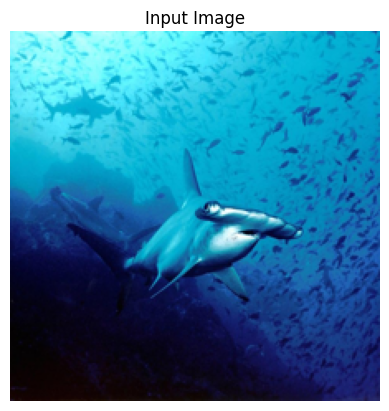

In [3]:
# Download sample image
sample_url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
image_path = "sample_image.jpg"

if not os.path.exists(image_path):
    print("Downloading sample image...")
    urllib.request.urlretrieve(sample_url, image_path)
    print(f"✓ Image saved as {image_path}")

# Load image
img = load_image(image_path)
plt.imshow(img)
plt.title("Input Image")
plt.axis('off')
plt.show()

In [4]:
# Load VGG16 model
print("Loading VGG16...")
model = models.vgg16(pretrained=True)
model.to(device)
model.eval()
print("✓ Model loaded!")

Loading VGG16...


c:\Users\mahah\anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mahah\anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Model loaded!


In [5]:
# Get prediction
img_tensor = preprocess_image(img).to(device)

with torch.no_grad():
    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()

# Load class names
class_names = get_imagenet_labels()

# Display top 5 predictions
probs = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_idx = torch.topk(probs, 5)

print("\nTop 5 Predictions:")
print("="*60)
for i in range(5):
    print(f"{i+1}. {class_names[top5_idx[i]]:30s} {top5_prob[i].item()*100:5.2f}%")
print("="*60)


Top 5 Predictions:
1. hammerhead                     65.45%
2. great white shark              21.91%
3. tiger shark                     7.06%
4. electric ray                    1.46%
5. scuba diver                     1.16%


---
## 4. Standard Backpropagation (Baseline)

In [6]:
# Prepare input tensor with gradient tracking
img_tensor = preprocess_image(img).to(device)
img_tensor.requires_grad_(True)

# Forward pass
output = model(img_tensor)

# Backward pass for the predicted class
model.zero_grad()
output[0, pred_class].backward()

# Get gradients
standard_grads = img_tensor.grad.detach().cpu().numpy()[0]

print(f"Standard gradients shape: {standard_grads.shape}")
print(f"Range: [{standard_grads.min():.4f}, {standard_grads.max():.4f}]")

Standard gradients shape: (3, 224, 224)
Range: [-0.4005, 0.4778]


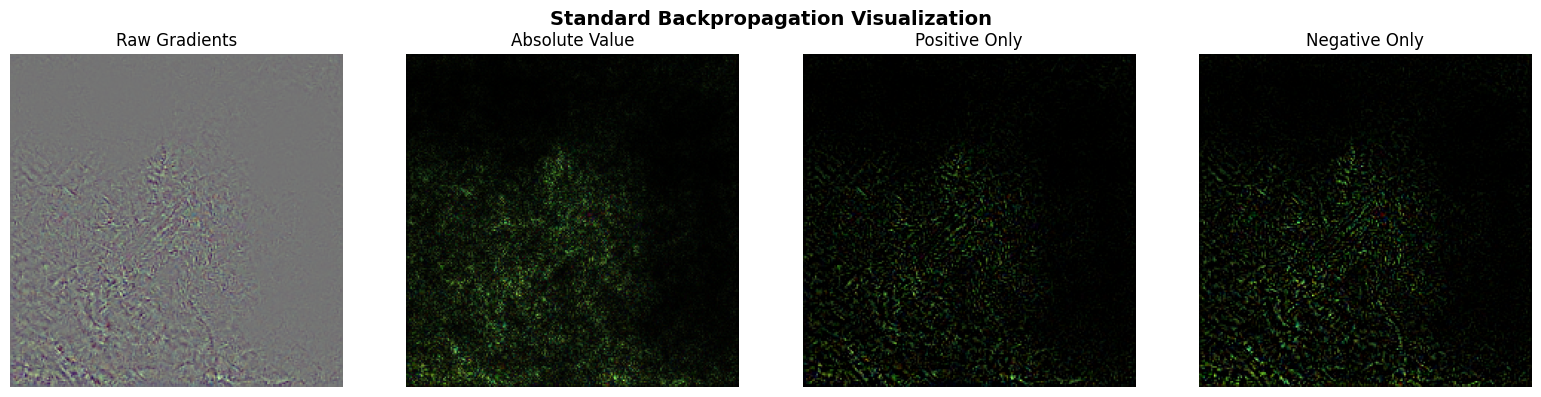


🔍 Observation: Standard backprop is noisy and hard to interpret!


In [7]:
# Visualize standard backprop with different methods
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

methods = ['raw', 'abs', 'positive', 'negative']
titles = ['Raw Gradients', 'Absolute Value', 'Positive Only', 'Negative Only']

for ax, method, title in zip(axes, methods, titles):
    vis = visualize_gradients(standard_grads, method=method)
    ax.imshow(vis)
    ax.set_title(title)
    ax.axis('off')

plt.suptitle("Standard Backpropagation Visualization", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔍 Observation: Standard backprop is noisy and hard to interpret!")

---
## 5. Guided Backpropagation Implementation

### Step 1: Replace In-Place ReLU

In-place operations can cause issues with gradient computation, so we replace them.

In [8]:
def replace_relu_inplace(model):
    """Replace all in-place ReLU with out-of-place ReLU."""
    count = 0
    for name, module in model.named_children():
        if isinstance(module, nn.ReLU):
            setattr(model, name, nn.ReLU(inplace=False))
            count += 1
        else:
            count += replace_relu_inplace(module)
    return count

num_replaced = replace_relu_inplace(model)
print(f"✓ Replaced {num_replaced} in-place ReLU layers")

✓ Replaced 15 in-place ReLU layers


### Step 2: Register Backward Hooks

The key to guided backprop: **Only propagate positive gradients** through ReLU layers.

In [9]:
def guided_relu_hook(module, grad_input, grad_output):
    """
    Guided backpropagation hook for ReLU layers.
    
    Only allows positive gradients to pass through.
    This creates sharper, cleaner visualizations.
    """
    # Get the gradient
    grad = grad_input[0]
    
    if grad is not None:
        # Keep only positive gradients (clamp negative to zero)
        modified_grad = torch.clamp(grad, min=0.0)
        return (modified_grad,)
    
    return grad_input

# Register hooks on all ReLU layers
hooks = []
for name, module in model.named_modules():
    if isinstance(module, nn.ReLU):
        hook = module.register_full_backward_hook(guided_relu_hook)
        hooks.append(hook)

print(f"✓ Registered {len(hooks)} guided backprop hooks on ReLU layers")

✓ Registered 15 guided backprop hooks on ReLU layers


### Step 3: Run Guided Backpropagation

In [10]:
# Prepare input
img_tensor = preprocess_image(img).to(device)
img_tensor.requires_grad_(True)

# Forward pass
output = model(img_tensor)

# Backward pass (with guided hooks active)
model.zero_grad()
output[0, pred_class].backward()

# Get guided gradients
guided_grads = img_tensor.grad.detach().cpu().numpy()[0]

print(f"Guided gradients shape: {guided_grads.shape}")
print(f"Range: [{guided_grads.min():.4f}, {guided_grads.max():.4f}]")

Guided gradients shape: (3, 224, 224)
Range: [-3.1200, 2.0141]


---
## 6. Compare Standard vs Guided Backprop

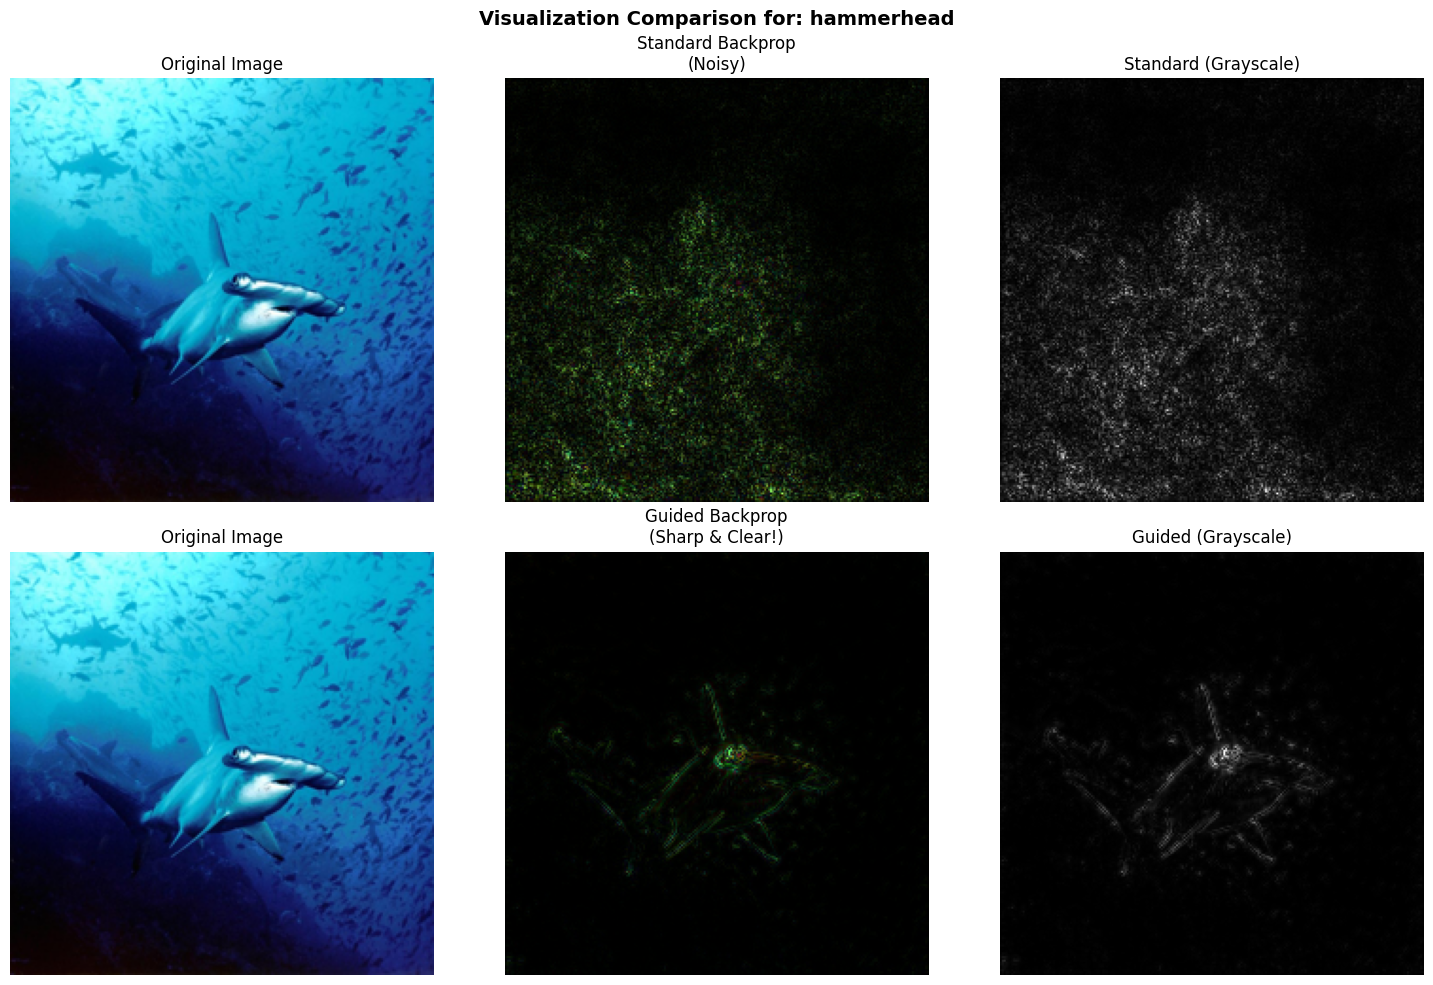


✨ Key Difference:
  Standard Backprop: Noisy, diffuse gradients
  Guided Backprop: Sharp, focused on important features!


In [11]:
# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Standard Backprop
axes[0, 0].imshow(img)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')

standard_vis = visualize_gradients(standard_grads, method='abs')
axes[0, 1].imshow(standard_vis)
axes[0, 1].set_title("Standard Backprop\n(Noisy)")
axes[0, 1].axis('off')

standard_gray = np.mean(standard_vis, axis=2)
axes[0, 2].imshow(standard_gray, cmap='gray')
axes[0, 2].set_title("Standard (Grayscale)")
axes[0, 2].axis('off')

# Row 2: Guided Backprop
axes[1, 0].imshow(img)
axes[1, 0].set_title("Original Image")
axes[1, 0].axis('off')

guided_vis = visualize_gradients(guided_grads, method='abs')
axes[1, 1].imshow(guided_vis)
axes[1, 1].set_title("Guided Backprop\n(Sharp & Clear!)")
axes[1, 1].axis('off')

guided_gray = np.mean(guided_vis, axis=2)
axes[1, 2].imshow(guided_gray, cmap='gray')
axes[1, 2].set_title("Guided (Grayscale)")
axes[1, 2].axis('off')

plt.suptitle(f"Visualization Comparison for: {class_names[pred_class]}", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✨ Key Difference:")
print("  Standard Backprop: Noisy, diffuse gradients")
print("  Guided Backprop: Sharp, focused on important features!")

---
## 7. Input × Gradients (Enhanced Visualization)

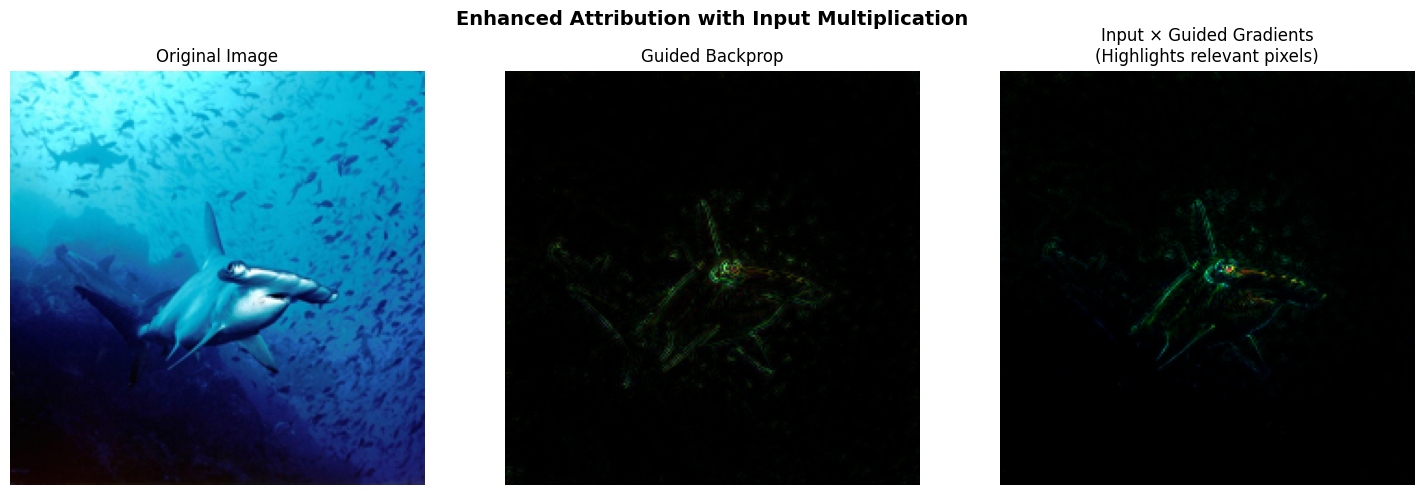


💡 Input × Gradients shows which ACTUAL PIXELS are important!


In [12]:
# Get unnormalized input
img_array = np.array(img) / 255.0
img_array = np.transpose(img_array, (2, 0, 1))  # (H,W,C) -> (C,H,W)

# Element-wise multiplication
input_x_grads = img_array * guided_grads

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Guided gradients
guided_vis = visualize_gradients(guided_grads, method='abs')
axes[1].imshow(guided_vis)
axes[1].set_title("Guided Backprop")
axes[1].axis('off')

# Input × Gradients
input_x_vis = visualize_gradients(input_x_grads, method='abs')
axes[2].imshow(input_x_vis)
axes[2].set_title("Input × Guided Gradients\n(Highlights relevant pixels)")
axes[2].axis('off')

plt.suptitle("Enhanced Attribution with Input Multiplication", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Input × Gradients shows which ACTUAL PIXELS are important!")

---
## 8. Complete Guided Backprop Class

In [ ]:
class GuidedBackprop:
    """
    Guided Backpropagation for CNN visualization.
    
    Paper: Striving for Simplicity: The All Convolutional Net
    https://arxiv.org/abs/1412.6806
    """
    
    def __init__(self, model):
        """
        Args:
            model: PyTorch CNN model
        """
        self.model = model
        self.hooks = []
        
        # Replace in-place ReLU
        self._replace_relu()
        
        # Register hooks
        self._register_hooks()
    
    def _replace_relu(self):
        """Replace in-place ReLU with out-of-place."""
        def replace(module):
            for name, child in module.named_children():
                if isinstance(child, nn.ReLU):
                    setattr(module, name, nn.ReLU(inplace=False))
                else:
                    replace(child)
        replace(self.model)
    
    def _guided_relu_hook(self, module, grad_input, grad_output):
        """Hook function for guided backprop."""
        grad = grad_input[0]
        if grad is not None:
            return (torch.clamp(grad, min=0.0),)
        return grad_input
    
    def _register_hooks(self):
        """Register hooks on ReLU layers."""
        for module in self.model.modules():
            if isinstance(module, nn.ReLU):
                hook = module.register_full_backward_hook(self._guided_relu_hook)
                self.hooks.append(hook)
    
    def generate(self, input_tensor, target_class=None):
        """
        Generate guided backprop visualization.
        
        Args:
            input_tensor: Input image tensor (1, C, H, W)
            target_class: Target class index (if None, use predicted)
        
        Returns:
            gradients: Guided backprop gradients (C, H, W)
            pred_class: Predicted class index
        """
        # Ensure gradients are enabled
        input_tensor = input_tensor.requires_grad_(True)
        
        # Forward pass
        output = self.model(input_tensor)
        
        # Get target class
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # Backward pass
        self.model.zero_grad()
        output[0, target_class].backward()
        
        # Get gradients
        gradients = input_tensor.grad.detach().cpu().numpy()[0]
        
        return gradients, target_class
    
    def visualize(self, input_tensor, img_pil, target_class=None, save_path=None):
        """
        Generate and visualize guided backprop.
        
        Args:
            input_tensor: Input tensor
            img_pil: Original PIL image
            target_class: Target class (if None, use predicted)
            save_path: Path to save visualization
        """
        # Generate gradients
        grads, pred_class = self.generate(input_tensor, target_class)
        
        # Visualize
        vis = visualize_gradients(grads, method='abs')
        
        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(img_pil)
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        axes[1].imshow(vis)
        axes[1].set_title("Guided Backprop")
        axes[1].axis('off')
        
        vis_gray = np.mean(vis, axis=2)
        axes[2].imshow(vis_gray, cmap='gray')
        axes[2].set_title("Grayscale")
        axes[2].axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"✓ Saved to {save_path}")
        
        plt.show()
        
        return vis, pred_class
    
    def __del__(self):
        """Remove hooks."""
        for hook in self.hooks:
            hook.remove()

print("✓ GuidedBackprop class defined!")

In [ ]:
# Test the class
guided_bp = GuidedBackprop(model)
vis, pred = guided_bp.visualize(img_tensor, img, save_path='guided_backprop_result.png')

---
## 9. Summary

### What We Learned:

1. **Standard Backpropagation**
   - Propagates all gradients (positive + negative)
   - Results in noisy visualizations

2. **Guided Backpropagation**
   - Only propagates positive gradients through ReLU
   - Results in sharp, interpretable visualizations
   - Better highlights relevant features

3. **Implementation Key Points**
   - Replace in-place ReLU
   - Register backward hooks on ReLU layers
   - Clamp negative gradients to zero

### Use Cases:
- Understanding what CNNs learn
- Debugging model decisions
- Creating saliency maps
- Feature visualization

### Next Steps:
- Try on your own images
- Combine with GradCAM (Guided Grad-CAM)
- Experiment with different architectures